# MedCLIP Captioning Model

In [1]:
import os
import collections
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
import tensorflow_text as text

from IPython.display import clear_output

import requests
from os.path import join, expanduser

from enum import Enum, auto

from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

import itertools

In [2]:
SEED = 111
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
class Database(Enum):
    MedPix = auto()
    CheXpert = auto()

In [4]:
# Select current database
CURRENT_DATABASE = Database.CheXpert

In [5]:
# Dataset files
DATASET_ROOT_DIR = 'datasets'

DATASET_DIR = ''
IMAGES_DIR = ''
DATASET_ANNOTATIONS = ''

if (CURRENT_DATABASE == Database.MedPix):
    DATASET_DIR = 'MedPix'
    IMAGES_DIR = 'cases_images'
    DATASET_ANNOTATIONS = 'Dataset_MedPix_V2.csv'
elif (CURRENT_DATABASE == Database.CheXpert):
    DATASET_DIR = 'CheXpert-v1.0-small'
    IMAGES_DIR = 'train'
    DATASET_ANNOTATIONS = 'Dataset_CheXpert.csv'
    
IMAGES_PATH = os.path.join(DATASET_ROOT_DIR, DATASET_DIR, IMAGES_DIR)
ANNOTATION_FILE = os.path.join(DATASET_ROOT_DIR, DATASET_DIR, DATASET_ANNOTATIONS)

# Model Weights
MODELS_ROOT_DIR = 'models'
MODEL_DIR = 'captioning_model_' + DATASET_DIR
WEIGHTS_FILE = 'weights'

MODEL_DIR_PATH = os.path.join(MODELS_ROOT_DIR, MODEL_DIR)
WEIGHTS_FILE_PATH = os.path.join(MODEL_DIR_PATH, WEIGHTS_FILE)

In [52]:
# Number of captions per image
CAPTIONS_PER_IMAGE = 1

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 5
AUTOTUNE = tf.data.AUTOTUNE

## Load dataset

In [7]:
annotations = pd.read_csv(ANNOTATION_FILE)

if (CURRENT_DATABASE == Database.CheXpert):
    annotations = annotations.sample(n=75000, random_state=45)

In [8]:
# Download MedPix image files
if (CURRENT_DATABASE == Database.MedPix and not os.path.exists(IMAGES_PATH)):
    for index, row in annotations.iterrows():
        url = row['Image_URL']
        file_name = str(index) + '.jpg'
        r = requests.get(url)
        filepath = join(root_dir, images_dir)

    if not os.path.exists(filepath):
        os.makedirs(filepath)

    filepath = join(filepath, file_name)

    if r.status_code == 200:
        with open(filepath, 'wb') as f:
            f.write(r.content)

print('Image files are downloaded in: ' + IMAGES_PATH)

Image files are downloaded in: datasets/CheXpert-v1.0-small/train


In [9]:
def load_captions_data():
    image_path_to_caption = collections.defaultdict(list)
    
    text_data = []

    for index, row in annotations.iterrows():
        caption = ''
        image_path = ''
        
        if (CURRENT_DATABASE == Database.MedPix):
            image_path = IMAGES_PATH + "/" + str(row['ID']) + ".jpg"
            
            caption = ('<start> ' + 'Modality: ' + str(row['Core_Modality']) + ', ' +
                       'Plane: ' + str(row['Plane']) + ', ' +
                       'Category: ' + str(row['Category']) + ', ' +
                       'Diagnosis: ' + str(row['Caption']) + ' <end>')
        elif (CURRENT_DATABASE == Database.CheXpert):
            image_path = DATASET_ROOT_DIR + "/" + str(row['Path'])
            
            ap_pa = ''
            if str(row['Frontal/Lateral']) == 'Frontal':
                ap_pa = 'AP/PA: ' + str(row['AP/PA']) + ', '
            
            caption = ('<start> ' + 'Frontal/Lateral: ' + str(row['Frontal/Lateral']) + ', ' +
                       ap_pa + 'Diagnosis: ' + str(row['Caption']) + ' <end>')
        
        image_path_to_caption[image_path].append(caption)
        
        text_data.append(caption)

    return image_path_to_caption, text_data

In [10]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

In [11]:
# Load the dataset
captions_mapping, text_data = load_captions_data()

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  60000
Number of validation samples:  15000


In [12]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [13]:
strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

# To keep caption the structure
strip_chars = strip_chars.replace(":", "")
strip_chars = strip_chars.replace(",", "")
strip_chars = strip_chars.replace("/", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [14]:
def decode_and_resize(img_path, size=IMAGE_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img


def read_train_image(img_path, size=IMAGE_SIZE):
    img = decode_and_resize(img_path)
    img = image_augmentation(tf.expand_dims(img, 0))[0]
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def read_valid_image(img_path, size=IMAGE_SIZE):
    img = decode_and_resize(img_path)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def make_dataset(images, captions, split="train"):
    if split == "train":
        img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
            read_train_image, num_parallel_calls=AUTOTUNE
        )
    else:
        img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
            read_valid_image, num_parallel_calls=AUTOTUNE
        )

    cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )

    dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset

In [15]:
# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(
    list(train_data.keys()), list(train_data.values()), split="train"
)

valid_dataset = make_dataset(
    list(valid_data.keys()), list(valid_data.values()), split="valid"
)

## Define the models

In [16]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB3(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [17]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=CAPTIONS_PER_IMAGE,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

In [18]:
# Initialize the model
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder 
)

## Train the model

In [19]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [20]:
# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

In [21]:
# Plot callback
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self):
        self.epochs = []
        self.times = []
        self.timetaken = 0
    
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
    
    def on_epoch_begin(self, epoch, logs={}):
        self.timetaken = tf.timestamp()
            
    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
                
        # Storing time
        self.times.append((tf.timestamp() - self.timetaken) / 60)
        self.epochs.append(epoch + 1)
        
        # Plot accuracy and loss per epoch
        metrics = [x for x in logs if 'val' not in x]
        
        fig = plt.figure(figsize=(12, 8))
        fig.set_facecolor('white')
        
        subfigs = fig.subfigures(2, 1)
        
        subplots = subfigs[0].subplots(1, len(metrics))
        
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            metricVarName = 'accuracy' if metric == 'acc' else metric
            
            subplots[i].plot(range(1, epoch + 2), self.metrics[metric], label=metricVarName)
            
            if logs['val_' + metric]:
                subplots[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], 
                                 label='val_' + metricVarName)
            
            metricLabel = 'Accuracy' if metric == 'acc' else 'Loss'
            
            subplots[i].set_title('Model ' + metricLabel)
            subplots[i].set_ylabel(metricLabel)
            subplots[i].set_xlabel('Epoch')
            subplots[i].legend()
            subplots[i].grid()
            
        # Plot time per epoch
        subplots = subfigs[1].subplots(1, 1)
        
        subplots.set_title('Minutes per epoch - Total time ' + 
                  str(round(np.sum(self.times) / 60, 2)) + 'hrs')
        subplots.set_xlabel('Epoch')
        subplots.set_ylabel('Time in minutes')
        subplots.plot(self.epochs, self.times)
        subplots.grid()
        
        bboxprops = dict(boxstyle='round', facecolor='white', alpha=0.75)
        
        for i in range(len(self.epochs)):
            j = self.times[i].numpy()
            subplots.text(i + 1, j, str(round(j, 2)), bbox=bboxprops)
        
        plt.tight_layout(rect=[-0.05, 0.05, 1, 0.92])
        plt.show()

In [22]:
# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-3, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

In [ ]:
# Load the model weights
print('Loading model weights...')

caption_model.load_weights(WEIGHTS_FILE_PATH)

print('Model weights loaded from: ' + WEIGHTS_FILE_PATH)

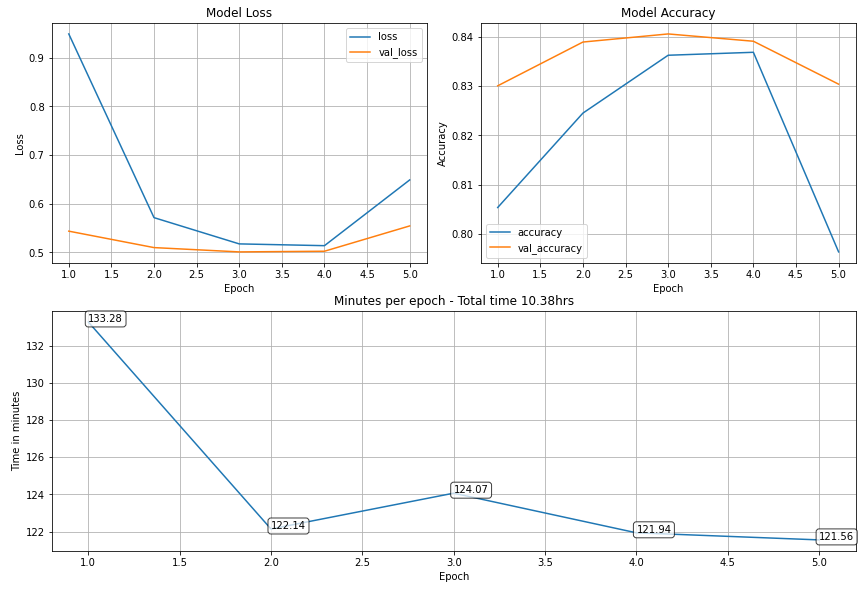

In [23]:
# Fit the model
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, PlotLearning()],
)

In [24]:
# Save the model weights
print("Saving model weights...")

caption_model.save_weights(WEIGHTS_FILE_PATH, save_format='tf')

print('Weights are saved in: ' + WEIGHTS_FILE_PATH)

Saving model weights...
Weights are saved in: models/captioning_model_CheXpert-v1.0-small/weights


## Test the model

In [34]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

In [67]:
def generate_caption(path, plotImage):
    # Read the image from the disk
    sample_img = read_valid_image(path)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    
    if plotImage:
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    
    # Remove decoded caption duplicates
    if (CURRENT_DATABASE == Database.CheXpert):
        words_set = set(decoded_caption.split())
        decoded_caption = ' '.join(sorted(words_set, key=decoded_caption.index))
    
    return decoded_caption

In [36]:
def generate_random_caption():
    image_path = np.random.choice(valid_images)
    print("Image Path: " + image_path)
    
    print(generate_caption(image_path, True))

In [37]:
def generate_caption_with_path(path):
    print("Image Path: " + path)
    
    print(generate_caption(path, True))

Image Path: datasets/CheXpert-v1.0-small/train/patient23056/study1/view1_frontal.jpg


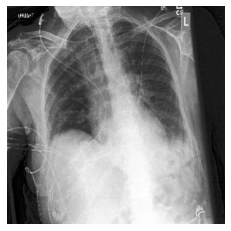

frontal/lateral: frontal, ap/pa: ap, diagnosis: lung opacity, edema, pleural effusion


In [72]:
generate_random_caption()

Image Path: datasets/CheXpert-v1.0-small/train/patient58473/study1/view1_frontal.jpg


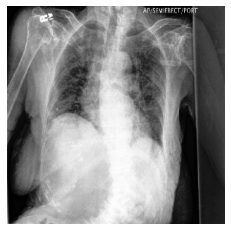

frontal/lateral: frontal, ap/pa: ap, diagnosis: lung opacity, pleural effusion


In [78]:
generate_random_caption()

Image Path: datasets/CheXpert-v1.0-small/train/patient13541/study3/view2_lateral.jpg


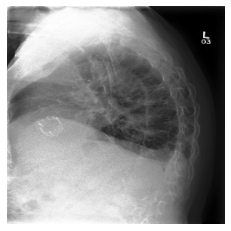

frontal/lateral: lateral, diagnosis: lung opacity, pleural effusion consolidation,


In [109]:
generate_random_caption()

## Evaluate scores

In [129]:
# BLEU & ROUGE Score
def evaluate_bleu_and_rouge_score(image_paths):
    gramScores = [0, 0, 0, 0]
    f_p_r_measures = [0, 0, 0]
    
    bleuWeights = [(1, 0, 0, 0), (0, 1, 0, 0), (1, 0, 1, 0), (0, 0, 0, 1)]
    for path, captions in tqdm(image_paths.items()):
        test_caption = generate_caption(path, False).split()
        hypo_captions = np.array(captions, copy=True).tolist()
        
        for i in range(len(hypo_captions)):
            hypo_captions[i] = hypo_captions[i].replace("<start> ", "")
            hypo_captions[i] = hypo_captions[i].replace(" <end>", "")
            hypo_captions[i] = hypo_captions[i].lower()
            hypo_captions[i] = hypo_captions[i].split()
        
        # BLEU Score
        for i in range(len(gramScores)):
            gramScores[i] += sentence_bleu(hypo_captions, test_caption, weights=bleuWeights[i])
        
        # ROUGE Score
        result = text.metrics.rouge_l(tf.ragged.constant(hypo_captions), 
                                    tf.ragged.constant([test_caption]))
        
        f_p_r_measures[0] += result.f_measure.numpy()[0]
        f_p_r_measures[1] += result.p_measure.numpy()[0]
        f_p_r_measures[2] += result.r_measure.numpy()[0]
    
    for i in range(len(gramScores)):
        print('BLEU Score ' + str(i+1) + ' gram: ' + str(gramScores[i] / len(image_paths)))
    
    print()
    print('ROUGE F Score: ' + str(f_p_r_measures[0] / len(image_paths)))
    print('ROUGE P Score: ' + str(f_p_r_measures[1] / len(image_paths)))
    print('ROUGE R Score: ' + str(f_p_r_measures[2] / len(image_paths)))

In [130]:
# Evaluate valid data BLEU & ROUGE score
evaluate_bleu_and_rouge_score(dict(itertools.islice(valid_data.items(), 5000)))

100%|██████████| 5000/5000 [1:03:14<00:00,  1.32it/s]

BLEU Score 1 gram: 0.6918095003453407
BLEU Score 2 gram: 0.5834899652749517
BLEU Score 3 gram: 0.3570143936546368
BLEU Score 4 gram: 0.37605258948251225

ROUGE F Score: 0.7529163469195366
ROUGE P Score: 0.8096366511940956
ROUGE R Score: 0.7182772243320942


In [ ]:
# Evaluate train data BLEU & ROUGE score
evaluate_bleu_and_rouge_score(train_data)